## Capstone: Modelling - Log Y

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from scipy import stats
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler

### Introduction

- Based on the feature selection and engineering section, the linear model with Y transformed performed significantly better. 
- Taking the logarithm of Y has reduced the variance and made the distribution more normal and less sensitive to outliers. We have a number of players with extremely high and low market value, the logarithm should minimise the impact of this. 
- I will trial the modelling process with this transformation on each of the best models from the previous section by model type. 

Data: https://drive.google.com/drive/folders/1ePqWsQ24m9TTHsZbgTmQ0nIz-uSTCAWR?usp=sharing

In [2]:
player_df_reduced = pd.read_csv('../Notebook_Data_Exports/player_df_EDA.csv')

In [17]:
# Drop not needed columns & set index to player name and year
player_df_pre = player_df_reduced.drop(columns = ['file_name','full_name'])
player_df_pre.set_index('player_year_key', inplace = True)
player_df_pre['Log_MV'] = np.log(player_df_pre['market_value_in_eur'])
player_df_pre_log = player_df_pre.drop(columns = ['market_value_in_eur'])

### Train / Test Split

In [18]:
from sklearn.model_selection import train_test_split
X = player_df_pre_log.drop(columns = 'Log_MV')
y = player_df_pre['Log_MV']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

### Model Evaluator

The function below will be used to evaluate all models based on regression modelling evaluators. It returns the train and test results for MAE, MSE, RMSE, and R-squared in a single dataframe. 

In [19]:
def regression_model_evaluation (model, X_train = X_train, X_test = X_test, y_train = y_train, y_test = y_test):
    
    # Get best model
    best_model = model.best_estimator_
    best_score_model = model.best_score_
    best_score = round(best_score_model*-1,2)

    best_parameters = model.best_params_
    
    # Evaluation metrics
    y_train_pred = best_model.predict(X_train)
    y_test_pred = best_model.predict(X_test)
    
    train_MAE = mean_absolute_error(y_train, y_train_pred)
    test_MAE = mean_absolute_error(y_test, y_test_pred)
    
    train_MSE = mean_squared_error(y_train, y_train_pred)
    test_MSE = mean_squared_error(y_test, y_test_pred)
    
    train_RMSE = np.sqrt(train_MSE)
    test_RMSE = np.sqrt(test_MSE)
    
    train_R2 = r2_score(y_train, y_train_pred)
    test_R2 = r2_score(y_test, y_test_pred)

    metrics_df = pd.DataFrame({
        "Metric": ["MAE", "MSE", "RMSE", "R^2"],
        "Training Set": [f'{train_MAE:.2f}', f'{train_MSE:.2f}', f'{train_RMSE:.2f}', f'{train_R2:.2f}'],
        "Test Set": [f'{test_MAE:.2f}', f'{test_MSE:.2f}', f'{test_RMSE:.2f}', f'{test_R2:.2f}']
    })
    
    output_string = f'best parameters = {best_parameters}\n\n' + \
                    f'best score = {best_score}\n\n' + \
                    f'{metrics_df}'
    print(output_string)      

### Linear Regression Pipeline

In [20]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, cross_val_score
from tempfile import mkdtemp
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

## Ridge Model - Log Y: 

In [21]:
from sklearn.feature_selection import SelectKBest, f_regression

best parameters = {'kbest__k': 150, 'ridge__alpha': 1.0}

best score = 0.64

  Metric Training Set Test Set
0    MAE         0.46     0.47
1    MSE         0.37     0.36
2   RMSE         0.61     0.60
3    R^2         0.81     0.83


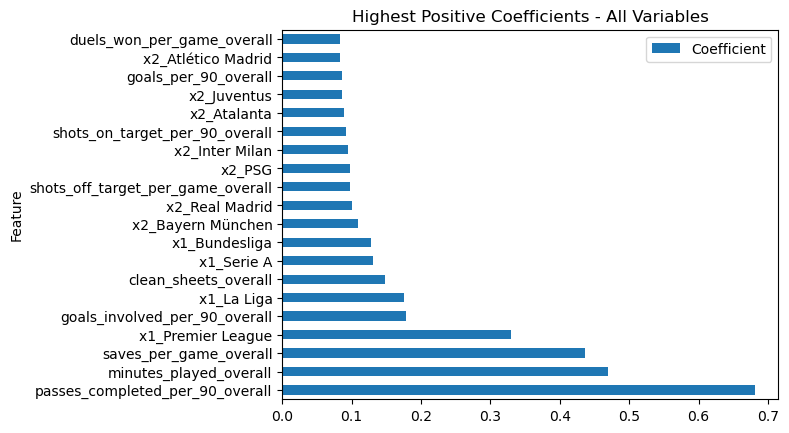

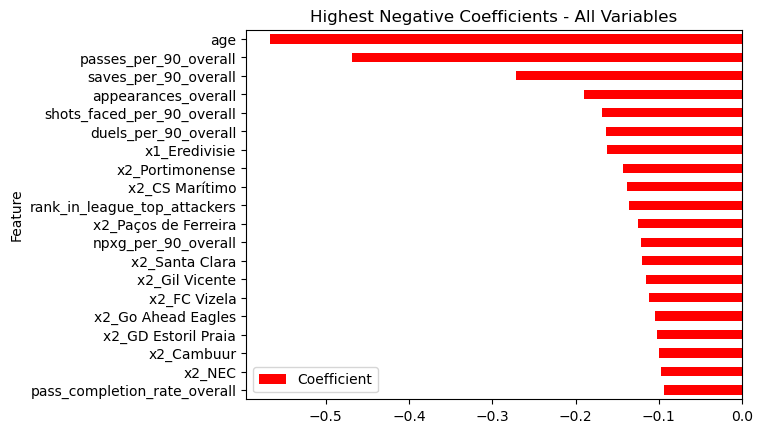

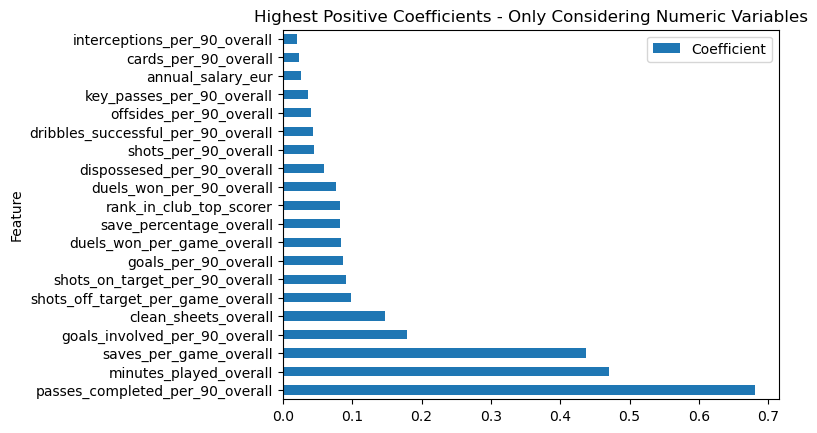

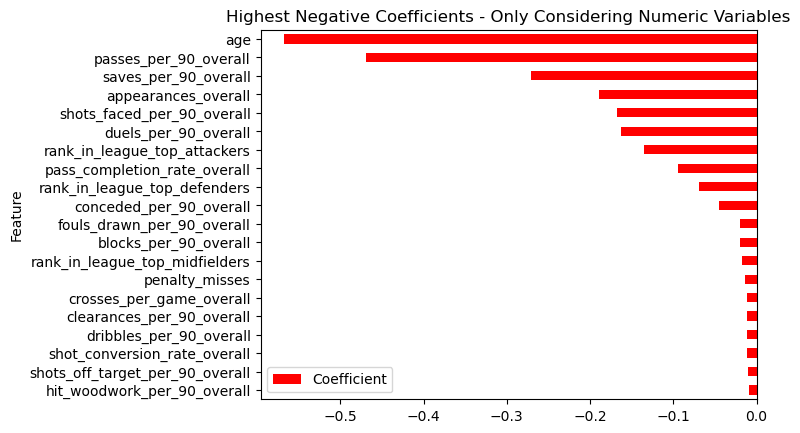

In [22]:
categorical_cols = ['position', 'league', 'Current Club', 'nationality', 'season']
numeric_cols = [col for col in X_train.columns if col not in categorical_cols]


# ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('numeric', 'passthrough', numeric_cols),  
        ('categorical', OneHotEncoder(handle_unknown='ignore'), categorical_cols) 
    ])

# Pipeline
Ridge_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('scaler', StandardScaler(with_mean=False)),
    ('kbest', SelectKBest(score_func=f_regression)),
    ('ridge', Ridge(random_state=1)) 
])

# Hyperparameters 
ridge_param_grid = {'ridge__alpha': [0.0001, 0.001, 0.1, 1.0, 50.0, 100.0],
                   'kbest__k': [150]}  

# Grid Search CV
ridge_grid_search = GridSearchCV(estimator=Ridge_pipeline,
                                 param_grid=ridge_param_grid,
                                 scoring='neg_root_mean_squared_error',
                                 cv=5)

# Fit the grid search to the training data
ridge_grid_search.fit(X_train, y_train)

# Model evaluation
regression_model_evaluation(ridge_grid_search)

# Fit the best estimator back into the pipeline - to enable getting the feature names
ridge_grid_search.best_estimator_.fit(X_train, y_train)

# Get categorical feature names
categorical_columns = list(ridge_grid_search.best_estimator_.named_steps['preprocessor'].transformers_[1][1].get_feature_names())

# Get numerical feature names
numeric_columns = list(ridge_grid_search.best_estimator_.named_steps['preprocessor'].transformers_[0][2])

# All columns
all_columns = numeric_columns + categorical_columns

# Selected Features 
selected_features_mask = ridge_grid_search.best_estimator_.named_steps['kbest'].get_support()
selected_features = [feature for feature, selected in zip(all_columns, selected_features_mask) if selected]

# Access coefficients from the pipeline
coefficients = ridge_grid_search.best_estimator_.named_steps['ridge'].coef_

# Create data frame of coefficients & features
coef_df_ridge = pd.DataFrame({'Feature': selected_features, 'Coefficient': coefficients})

# Top positive coefficients - ALL
all_features_high = coef_df_ridge.sort_values('Coefficient', ascending = False).head(20)\
.set_index('Feature').plot(kind = 'barh')
plt.title('Highest Positive Coefficients - All Variables')

# Top negative coefficients - ALL
all_features_low = coef_df_ridge.sort_values('Coefficient', ascending = False).tail(20)\
.set_index('Feature').plot(kind = 'barh', color = 'red')
plt.title('Highest Negative Coefficients - All Variables')

# Top positive numeric coefficients
numeric_only_high = coef_df_ridge[~coef_df_ridge['Feature'].str.contains('x')]\
.sort_values('Coefficient', ascending = False).head(20).set_index('Feature')\
.plot(kind = 'barh')
plt.title('Highest Positive Coefficients - Only Considering Numeric Variables')

# Top negative numeric coefficients 
numeric_only_low = coef_df_ridge[~coef_df_ridge['Feature'].str.contains('x')]\
.sort_values('Coefficient', ascending = False).tail(20).set_index('Feature').plot(kind = 'barh', color = 'red')
plt.title('Highest Negative Coefficients - Only Considering Numeric Variables')
plt.show()

## Lasso Model - Log Y: 

/Users/cristopherhesketh/anaconda3/envs/capstone/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:513: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 406.01331674758694, tolerance: 0.760672914761324
  model = cd_fast.sparse_enet_coordinate_descent(
/Users/cristopherhesketh/anaconda3/envs/capstone/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:513: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 315.4974686238314, tolerance: 0.7543957826691503
  model = cd_fast.sparse_enet_coordinate_descent(
/Users/cristopherhesketh/anaconda3/envs/capstone/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:513: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 444.91339494972664, tolerance: 0.7469902668379816
  model = cd_fast.sparse_enet_co

best parameters = {'kbest__k': 100, 'lasso__alpha': 0.0001, 'lasso__max_iter': 50000}

best score = 0.69

  Metric Training Set Test Set
0    MAE         0.52     0.52
1    MSE         0.45     0.43
2   RMSE         0.67     0.66
3    R^2         0.77     0.79


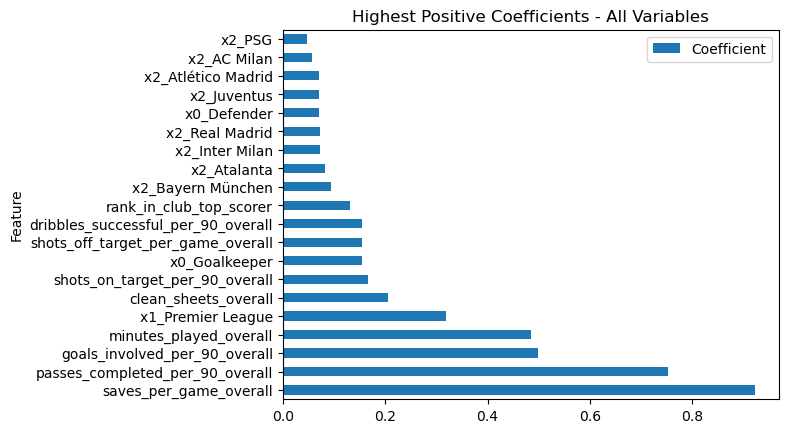

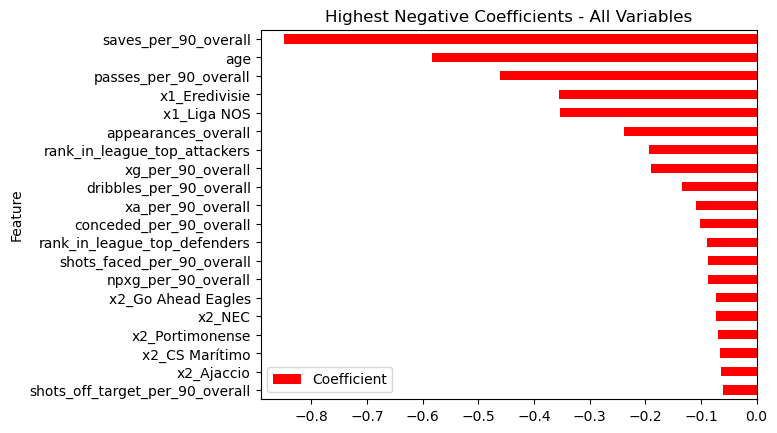

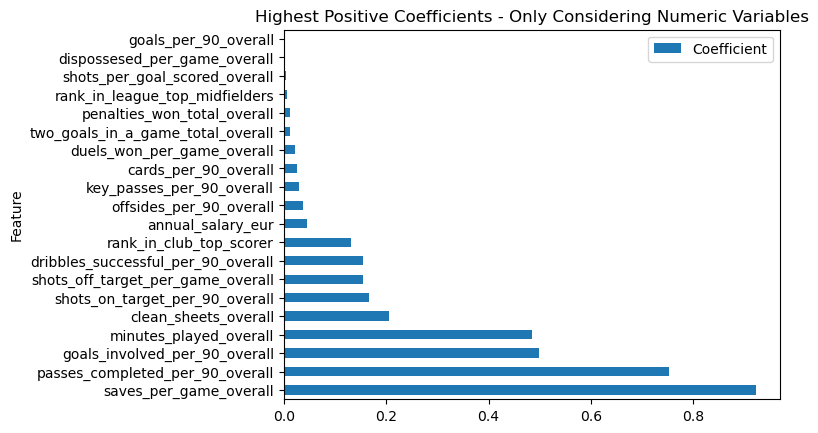

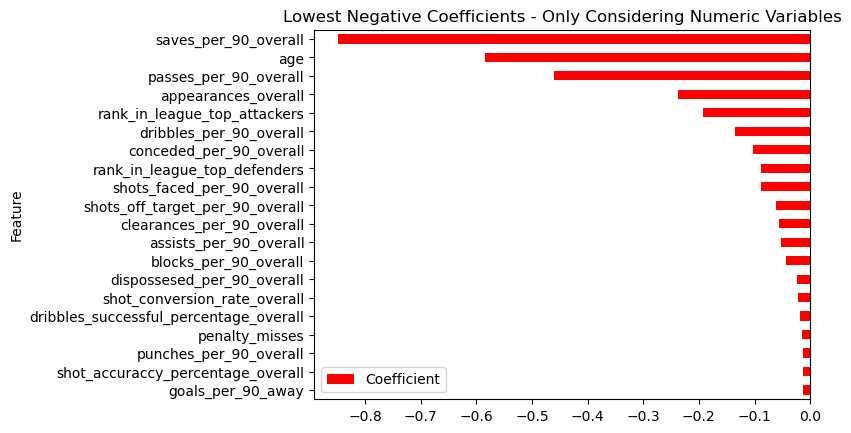

In [23]:
categorical_cols = ['position', 'league', 'Current Club', 'nationality', 'season']
numeric_cols = [col for col in X_train.columns if col not in categorical_cols]

# ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('numeric', 'passthrough', numeric_cols),  
        ('categorical', OneHotEncoder(handle_unknown='ignore'), categorical_cols) 
    ])

# Pipeline
Lasso_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('scaler', StandardScaler(with_mean=False)),
    ('kbest', SelectKBest(score_func=f_regression)),
    ('lasso', Lasso(random_state=1)) 
])

# Define the hyperparameters to tune
lasso_param_grid = {'lasso__alpha': [0.000001, 0.00001, 0.0001, 0.001, 0.01, 0.1, 1],
                    'lasso__max_iter': [50000],
                   'kbest__k': [100]}  

# Create a gridsearchcv object with the param grid
lasso_grid_search = GridSearchCV(estimator=Lasso_pipeline,
                                 param_grid=lasso_param_grid,
                                 scoring='neg_root_mean_squared_error',
                                 cv=5)

# Fit the grid search to the training data
lasso_grid_search.fit(X_train, y_train)

# Model evaluation
regression_model_evaluation(lasso_grid_search)

# Fit the best estimator back into the pipeline - to enable getting the feature names
lasso_grid_search.best_estimator_.fit(X_train, y_train)

# Get categorical feature names
categorical_columns = list(lasso_grid_search.best_estimator_.named_steps['preprocessor'].transformers_[1][1].get_feature_names())

# Get numerical feature names
numeric_columns = list(lasso_grid_search.best_estimator_.named_steps['preprocessor'].transformers_[0][2])

# All columns
all_columns = numeric_columns + categorical_columns

# Selected Features 
selected_features_mask = lasso_grid_search.best_estimator_.named_steps['kbest'].get_support()
selected_features = [feature for feature, selected in zip(all_columns, selected_features_mask) if selected]

# Access coefficients from the pipeline
coefficients = lasso_grid_search.best_estimator_.named_steps['lasso'].coef_

# Create data frame of coefficients & features
coef_df_lasso = pd.DataFrame({'Feature': selected_features, 'Coefficient': coefficients})

# Top positive coefficients - ALL
all_features_high = coef_df_lasso.sort_values('Coefficient', ascending = False).head(20)\
.set_index('Feature').plot(kind = 'barh')
plt.title('Highest Positive Coefficients - All Variables')

# Top negative coefficients - ALL
all_features_low = coef_df_lasso.sort_values('Coefficient', ascending = False).tail(20)\
.set_index('Feature').plot(kind = 'barh', color = 'red')
plt.title('Highest Negative Coefficients - All Variables')

# Top positive numeric coefficients
numeric_only_high = coef_df_lasso[~coef_df_lasso['Feature'].str.contains('x')]\
.sort_values('Coefficient', ascending = False).head(20).set_index('Feature')\
.plot(kind = 'barh')
plt.title('Highest Positive Coefficients - Only Considering Numeric Variables')

# Top negative numeric coefficients 
numeric_only_low = coef_df_lasso[~coef_df_lasso['Feature'].str.contains('x')]\
.sort_values('Coefficient', ascending = False).tail(20).set_index('Feature').plot(kind = 'barh', color = 'red')
plt.title('Lowest Negative Coefficients - Only Considering Numeric Variables')
plt.show()

## Decision Tree: Regression

In [24]:
from sklearn.tree import DecisionTreeRegressor

python(62682) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(62683) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(62684) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(62685) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(62686) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(62687) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(62688) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(62689) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(62690) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(62691) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


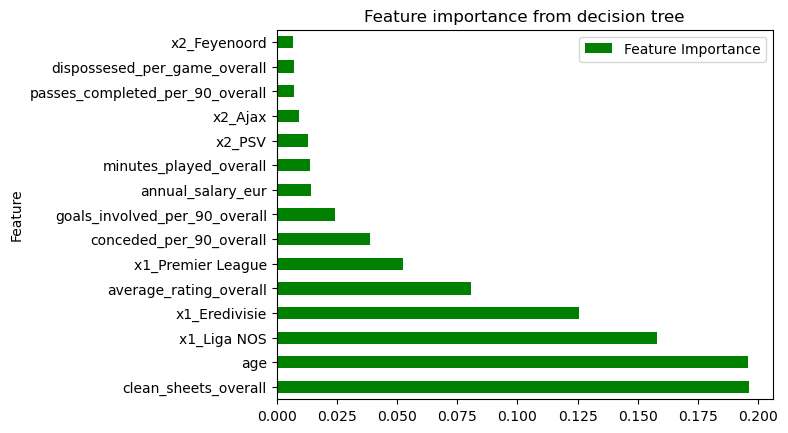

best parameters = {'dt__criterion': 'mse', 'dt__max_depth': 10, 'dt__min_samples_leaf': 10, 'dt__min_samples_split': 40}

best score = 0.9

  Metric Training Set Test Set
0    MAE         0.55     0.68
1    MSE         0.51     0.76
2   RMSE         0.71     0.87
3    R^2         0.74     0.64


In [25]:
categorical_cols = ['position', 'league', 'Current Club', 'nationality', 'season']
numeric_cols = [col for col in X_train.columns if col not in categorical_cols]

# Define ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('numeric', StandardScaler(), numeric_cols),  
        ('categorical', OneHotEncoder(handle_unknown='ignore'), categorical_cols)  
    ])

# Create pipeline
dt_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('dt', DecisionTreeRegressor(random_state=1))
])

# Hyperparameters
dt_param_grid = {
    'dt__max_depth':[5, 10, 15, 20, 30],
    'dt__criterion': ['mse', 'mae'],
    'dt__min_samples_leaf': [5, 10, 20, 30],
    'dt__min_samples_split': [20, 30, 40]     
}

# Grid_Search 
dt_grid_search = GridSearchCV(estimator=dt_pipeline,
                                 param_grid=dt_param_grid,
                                 scoring='neg_root_mean_squared_error',
                                 cv=5,
                             n_jobs=-1)
# Fit on training data
dt_grid_search.fit(X_train, y_train)

# Fit on best model 
best_decision_tree_model = dt_grid_search.best_estimator_.fit(X_train, y_train)

# Get categorical feature names
categorical_columns = list(dt_grid_search.best_estimator_.named_steps['preprocessor'].transformers_[1][1].get_feature_names())

# Get numerical feature names
numeric_columns = list(dt_grid_search.best_estimator_.named_steps['preprocessor'].transformers_[0][2])

# All columns
all_columns = numeric_columns + categorical_columns

# Feature importance
feature_importances = best_decision_tree_model.named_steps['dt'].feature_importances_

# Create data frame of coefficients & features
feature_df_dt = pd.DataFrame({'Feature': all_columns, 'Feature Importance': feature_importances})

# Plot feature importance
feature_df_dt.sort_values('Feature Importance', ascending = False).head(15)\
.set_index('Feature').plot(kind = 'barh', color = 'green')
plt.title('Feature importance from decision tree')
plt.show()

# Model evaluation
regression_model_evaluation(dt_grid_search)

### Insight
Noting the first decision tree with age as a continuous variable performed much better, I expect this is due to the depth in the decision tree not enabling enough specificity in the model. I have increased the max depth to attempt to get more accurate results, this causes a risk of overfitting. 

## K Nearest Neighbours

In [26]:
from sklearn.neighbors import KNeighborsRegressor

In [27]:
categorical_cols = ['position', 'league', 'Current Club', 'nationality', 'season']
numeric_cols = [col for col in X_train.columns if col not in categorical_cols]


# ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('numeric', 'passthrough', numeric_cols),  
        ('categorical', OneHotEncoder(handle_unknown='ignore'), categorical_cols) 
    ])


# Create pipeline
knn_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('scaler', StandardScaler(with_mean=False)),
    ('knn', KNeighborsRegressor())
])

# Parameter Grid
knn_param_grid = {
    'knn__n_neighbors':[5, 6 ,7, 8, 9, 10],
    'knn__weights':['uniform', 'distance'],
    'knn__algorithm': ['auto']

}

# Grid_Search 
knn_grid_search = GridSearchCV(estimator=knn_pipeline,
                                 param_grid=knn_param_grid,
                                 scoring='neg_root_mean_squared_error',
                                 cv=5)
# Fit on training data
knn_grid_search.fit(X_train, y_train)

# Model evaluation
regression_model_evaluation(knn_grid_search)

best parameters = {'knn__algorithm': 'auto', 'knn__n_neighbors': 8, 'knn__weights': 'distance'}

best score = 0.9

  Metric Training Set Test Set
0    MAE         0.00     0.70
1    MSE         0.00     0.78
2   RMSE         0.00     0.88
3    R^2         1.00     0.63


Note. The model is overfitted when we re-fit on X and Y-train, the model has remembered the positions of all of the data points and is able to recall them. The test set is the only valuable figure here. 

### Random Forest

In [28]:
from sklearn.utils import resample
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV

best parameters = {'rf__max_depth': 30, 'rf__max_features': 'auto', 'rf__min_samples_leaf': 6, 'rf__min_samples_split': 10, 'rf__n_estimators': 50}

best score = 0.75

  Metric Training Set Test Set
0    MAE         0.35     0.56
1    MSE         0.22     0.52
2   RMSE         0.47     0.72
3    R^2         0.89     0.75


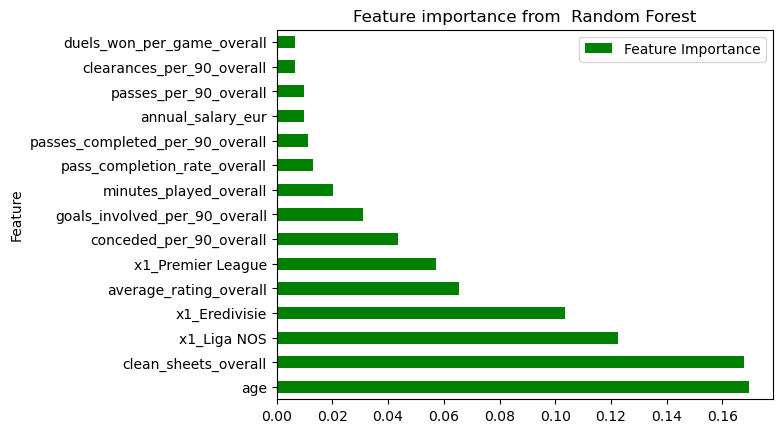

In [29]:
categorical_cols = ['position', 'league', 'Current Club', 'nationality', 'season']
numeric_cols = [col for col in X_train.columns if col not in categorical_cols]

# Define ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('numeric', StandardScaler(), numeric_cols), 
        ('categorical', OneHotEncoder(handle_unknown='ignore'), categorical_cols) 
    ])

# Create pipeline
random_forest_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('rf', RandomForestRegressor())
])

# Parameter Grid
rf_param_grid = {
     'rf__n_estimators': [10, 20, 30, 40, 50],
    'rf__max_depth': [None, 10, 20, 30],
    'rf__min_samples_split':  [10, 15, 20],
    'rf__min_samples_leaf': [6, 8, 10],
    'rf__max_features': ['auto', 'sqrt', 'log2']

}

# Grid_Search 
rf_grid_search = GridSearchCV(estimator=random_forest_pipeline,
                                 param_grid=rf_param_grid,
                                 scoring='neg_root_mean_squared_error',
                                 cv=5,
                                 n_jobs=-1)
# Fit on training data
rf_grid_search.fit(X_train, y_train)

# Fit on best model 
best_rf_model = rf_grid_search.best_estimator_.fit(X_train, y_train)

# Get categorical feature names
categorical_columns = list(rf_grid_search.best_estimator_.named_steps['preprocessor'].transformers_[1][1].get_feature_names())

# Get numerical feature names
numeric_columns = list(rf_grid_search.best_estimator_.named_steps['preprocessor'].transformers_[0][2])

# All columns
all_columns = numeric_columns + categorical_columns

# Feature importance
feature_importances = best_rf_model.named_steps['rf'].feature_importances_

# Create data frame of coefficients & features
feature_rf_dt = pd.DataFrame({'Feature': all_columns, 'Feature Importance': feature_importances})

# Model evaluation
regression_model_evaluation(rf_grid_search) 

# Plot feature importance
feature_rf_dt.sort_values('Feature Importance', ascending = False).head(15)\
.set_index('Feature').plot(kind = 'barh', color = 'green')
plt.title('Feature importance from  Random Forest')
plt.show()

### xg boost

In [30]:
import xgboost as xgb
from xgboost import XGBRegressor

best parameters = {'xgb__alpha': 0.1, 'xgb__learning_rate': 0.2, 'xgb__max_depth': 4, 'xgb__n_estimators': 200}

best score = 0.63

  Metric Training Set Test Set
0    MAE         0.29     0.46
1    MSE         0.15     0.36
2   RMSE         0.38     0.60
3    R^2         0.93     0.83


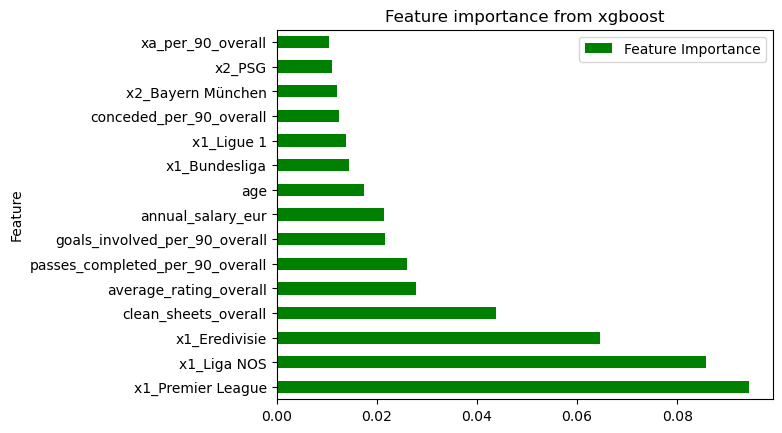

In [31]:
categorical_cols = ['position', 'league', 'Current Club', 'nationality', 'season']
numeric_cols = [col for col in X_train.columns if col not in categorical_cols]

# Define ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('numeric', 'passthrough', numeric_cols),  
        ('categorical', OneHotEncoder(handle_unknown='ignore'), categorical_cols)  
    ])

# Create pipeline
xgb_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('scaler', StandardScaler(with_mean=False)),
    ('xgb', XGBRegressor())
])

# Parameter Grid
xgb_param_grid = {
    'xgb__learning_rate': [0.1, 0.2, 0.3],
    'xgb__n_estimators': [100, 200],
    'xgb__alpha': [0.01, 0.1, 1, 10, 100],
    'xgb__max_depth': [3, 4, 5, 6, 7],

}

# Grid_Search 
xgb_grid_search = GridSearchCV(estimator=xgb_pipeline,
                                 param_grid=xgb_param_grid,
                                 scoring='neg_root_mean_squared_error',
                                 cv=5,
                                 n_jobs=-1)

# Fit on training data
xgb_grid_search.fit(X_train, y_train)

# Fit on best model 
best_xgb_model = xgb_grid_search.best_estimator_.fit(X_train, y_train)

# Get categorical feature names
categorical_columns = list(best_xgb_model.named_steps['preprocessor'].transformers_[1][1].get_feature_names())

# Get numerical feature names
numeric_columns = list(best_xgb_model.named_steps['preprocessor'].transformers_[0][2])

# All columns
all_columns = numeric_columns + categorical_columns

# Feature importance
feature_importances = best_xgb_model.named_steps['xgb'].feature_importances_

# Create data frame of coefficients & features
feature_xgb_dt = pd.DataFrame({'Feature': all_columns, 'Feature Importance': feature_importances})

# Model evaluation
regression_model_evaluation(xgb_grid_search) 

# Plot feature importance
feature_xgb_dt.sort_values('Feature Importance', ascending = False).head(15)\
.set_index('Feature').plot(kind = 'barh', color = 'green')
plt.title('Feature importance from xgboost')
plt.show()

The model is still highly overfitted, even though the performance on the test data is high I have performed further measures to reduce the number of estimators and increase regularisation strength. 

### Model Selection

A summary of the modelling is found below:

In [32]:
list_of_model_names = ['ridge_grid_search',
 'lasso_grid_search',
 'dt_grid_search',
 'knn_grid_search',
 'rf_grid_search',
 'xgb_grid_search']

list_of_models = [ridge_grid_search,
 lasso_grid_search,
 dt_grid_search,
 knn_grid_search,
 rf_grid_search,
 xgb_grid_search]

list_of_scores = []
for model in list_of_models:
    score = round((model.best_score_*-1),2)
    list_of_scores.append(score)
    
score_df = pd.DataFrame({'Model':list_of_model_names, 'RMSE Score': list_of_scores})
score_df

,Model,RMSE Score
0,ridge_grid_search,0.64
1,lasso_grid_search,0.69
2,dt_grid_search,0.90
3,knn_grid_search,0.90
4,rf_grid_search,0.75
5,xgb_grid_search,0.63


Based on the evaluation criteria of minimising RMSE, the XGBoost model has the best performance, although the ridge score is also very close and much simpler model to interpret.

I will evaluate the two models below and take the exponent of the target variable, this is the most important measure rather then only the performance when comparing the Log of Y Predictions vs Actuals. 

In [33]:
# Evaluation Function 
regression_model_evaluation(xgb_grid_search)

best parameters = {'xgb__alpha': 0.1, 'xgb__learning_rate': 0.2, 'xgb__max_depth': 4, 'xgb__n_estimators': 200}

best score = 0.63

  Metric Training Set Test Set
0    MAE         0.29     0.46
1    MSE         0.15     0.36
2   RMSE         0.38     0.60
3    R^2         0.93     0.83


In [34]:
y_test_pred = xgb_grid_search.predict(X_test)

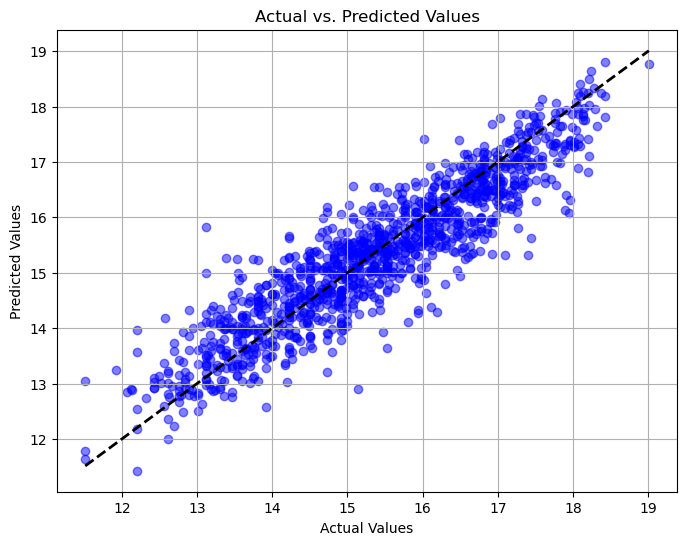

In [26]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_test_pred, color='blue', alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2) 
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs. Predicted Values')
plt.grid(True)
plt.show()

### Model evaluation after exponentiating Y-Test

In [42]:
# Take exponent of y_test and y_pred
y_test_exponentiated = np.exp(y_test)
y_pred_exponentiated = np.exp(y_test_pred)

In [50]:
# Evaluation metrics
exp_test_MAE = mean_absolute_error(y_test_exponentiated, y_pred_exponentiated)
exp_test_MSE = mean_squared_error(y_test_exponentiated, y_pred_exponentiated)
exp_test_RMSE = np.sqrt(exp_test_MSE)
exp_test_R2 = r2_score(y_test_exponentiated, y_pred_exponentiated)

metrics_df = pd.DataFrame({
    "Metric": ["MAE", "MSE", "RMSE", "R^2"],
    "Test Set": [f'{exp_test_MAE:.2f}', f'{exp_test_MSE:.2f}', f'{exp_test_RMSE:.2f}', f'{exp_test_R2:.2f}']
})

output_string = f'{metrics_df}'
print(output_string)      

  Metric           Test Set
0    MAE         4557649.40
1    MSE  79923607245359.59
2   RMSE         8940000.41
3    R^2               0.74


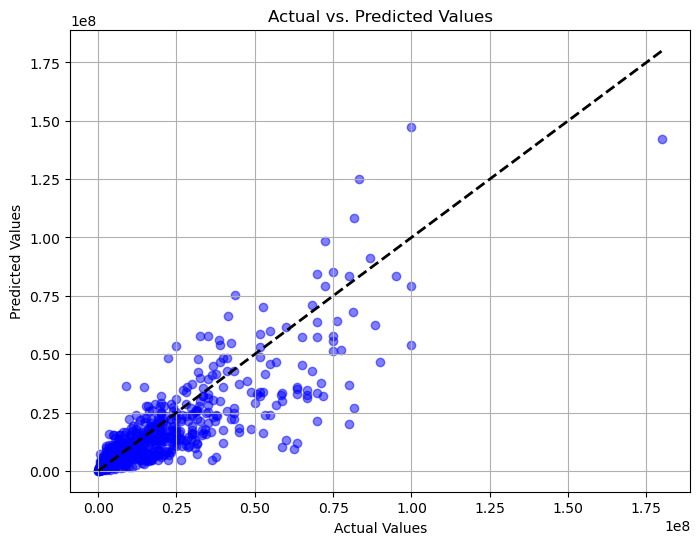

In [48]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test_exponentiated, y_pred_exponentiated, color='blue', alpha=0.5)
plt.plot([y_test_exponentiated.min(), y_test_exponentiated.max()], [y_test_exponentiated.min(), y_test_exponentiated.max()], 'k--', lw=2) 
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs. Predicted Values')
plt.grid(True)
plt.show()

#### Ridge Model 

In [51]:
# Predictions for ridge model
y_test_pred_ridge = ridge_grid_search.predict(X_test)

In [56]:
# Take exponent of y_test and y_pred
y_test_pred_ridge_exponentiated = np.exp(y_test_pred_ridge)

In [58]:
# Evaluation metrics
exp_test_MAE_ridge = mean_absolute_error(y_test_pred_ridge_exponentiated, y_test_exponentiated)
exp_test_MSE_ridge = mean_squared_error(y_test_pred_ridge_exponentiated, y_test_exponentiated)
exp_test_RMSE_ridge = np.sqrt(exp_test_MSE_ridge)
exp_test_R2_ridge = r2_score(y_test_pred_ridge_exponentiated, y_test_exponentiated)

metrics_df = pd.DataFrame({
    "Metric": ["MAE", "MSE", "RMSE", "R^2"],
    "Test Set": [f'{exp_test_MAE_ridge:.2f}', f'{exp_test_MSE_ridge:.2f}',
                 f'{exp_test_RMSE_ridge:.2f}', f'{exp_test_R2_ridge:.2f}']
})

output_string = f'{metrics_df}'
print(output_string)     

  Metric            Test Set
0    MAE          4897368.76
1    MSE  171132845230162.66
2   RMSE         13081775.31
3    R^2                0.62


#### Conclusion

Although when taking the log of Y the models looked to be performing better, after exponentiating the predictions and comparing the final values of Y, both of the best models in this section performed worse than the original models without the transformation. 

As such, the original models will be taken forward for the final product. 